## Plan

Итак, нам надо:
 - распаковать mp3 в массив чисел, представляющий собой график зависимости амплитуды звука от времени (sox)
 - определить, какие ноты звучат в каждый конкретный момент времени
 - определить, какие аккорды образуют эти ноты

### Итак, что происходит:
        
    Пытаемся получить chromagram (chroma feature - https://en.wikipedia.org/wiki/Chroma_feature)
    Чтобы определить, какие играют ноты
    Для начала мы удалим весь шум, чтобы выделить ноты поверх шума.
        
        Гармо́ника (лат. harmonica) — дополнительный тон, который по частоте всегда выше основного тона, причём строго кратно 
        числам натурального ряда (то есть, выше по частоте в 2, 3, 4, 5 и более раз).
        
    Получаю хромограмму песни!
    
    То есть есть ноты A B H C C#/Db D D#/Eb E F F#/Gb G G#/Ab
    мы получаем вектор значений какие ноты с какой силой играют
    и обучаем на аккордах по силе их нот
    
    Еще нужно сделать все взаимодействия именно с песней. Пока просто модели определяют по нотам аккорды

In [1]:
CHORD_PATH_FOR_TEST = "D:\\iba_project_data\\Guitar_Only\\c\\c8.wav"
TMP_SONG = "tmp.wav"

In [2]:
%matplotlib inline

# librosa - module for work with sounds

import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import scipy
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [3]:
# not used
def get_spec_from_wav(file_path, with_graphics=False):
    """
    Func gets spectogram from wav-file.
    
    Input:
        file_path - path to file with sound.
        with_graphics - paint graphics of wav and sperctogram.
    
    Return:
        Xdb - decibels.
        sr - Sample rate used to determine time scale. 
        (частота дискретизации) 
    
    """
    
    x, sr = librosa.load(file_path)
    if with_graphics:
        plt.figure(figsize=(14, 5))    
        librosa.display.waveplot(x, sr=sr)
    
    X = librosa.stft(x) # Short-time Fourier transform
    Xdb = librosa.amplitude_to_db(abs(X))
    
    if with_graphics:
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
        plt.colorbar()
    
    return Xdb, sr

In [4]:
def get_chromagram(file_path, with_graphics=False):
    """
    Func gets chromagram from wav-file.
    
    Input:
        file_path - path to file with sound.
        with_graphics - paint graphics of wav and sperctogram.
    
    Return:
        chroma_smooth - chromagram of audio record (n x 12(notes) list)
    
    """
    
    y, sr = librosa.load(file_path)
    chroma_orig = librosa.feature.chroma_cqt(y=y, sr=sr)        
    
    # We can correct for minor tuning deviations by using 3 CQT bins per semi-tone, instead of one
    chroma_os = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=12*3)

    #isolating the harmonic component. We’ll use a large margin for separating harmonics from percussives
    y_harm = librosa.effects.harmonic(y=y, margin=8)
    chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=sr, bins_per_octave=12*3)

    # non-local filtering
    # Each data point (e.g, spectrogram column) is replaced by aggregating its nearest neighbors in feature space.
    chroma_filter = np.minimum(chroma_os_harm,
                           librosa.decompose.nn_filter(chroma_os_harm,
                                                       aggregate=np.median,
                                                       metric='cosine'))

    # Local discontinuities and transients can be suppressed by using a horizontal median filter.
    chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))

    if with_graphics:
        # First, let’s plot the original chroma
        # For display purposes, let's zoom in on a 15-second chunk from the middle of the song
       # idx = tuple([slice(None), slice(*list(librosa.time_to_frames([45, 60])))])

        # And for comparison, we'll show the CQT matrix as well.
        C = np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=12*3, n_bins=7*12*3))


        plt.figure(figsize=(12, 4))
        plt.subplot(2, 1, 1)
        librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),#[idx],
                                 y_axis='cqt_note', x_axis='time', bins_per_octave=12*3)
        plt.colorbar()
        
        plt.subplot(2, 1, 2)
        librosa.display.specshow(chroma_smooth,#[idx], 
                                 y_axis='chroma', x_axis='time')
        plt.colorbar()
        plt.ylabel('Median-filtered')
        
        # Automatically adjust subplot parameters to give specified padding.
        plt.tight_layout()    
    return chroma_smooth

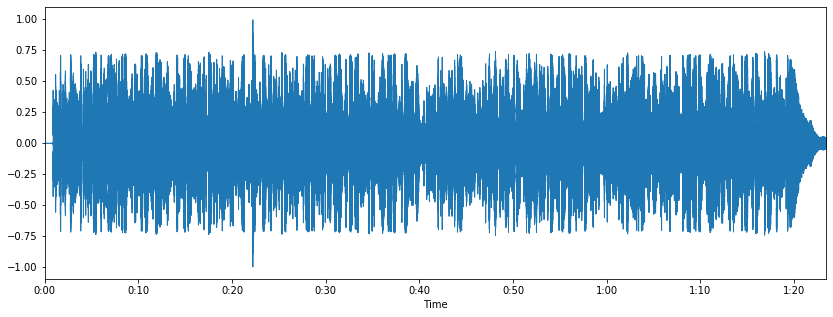

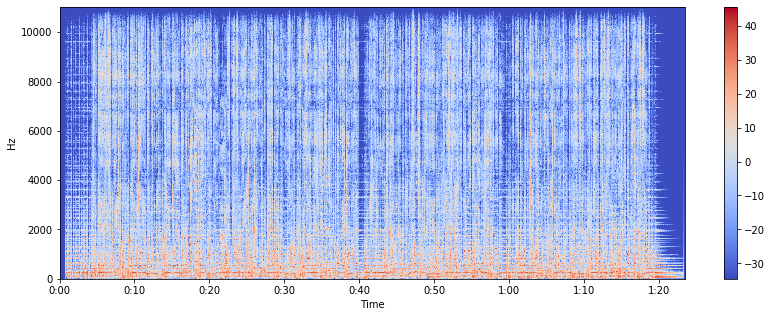

In [5]:
Xdb, sr = get_spec_from_wav(TMP_SONG, True)

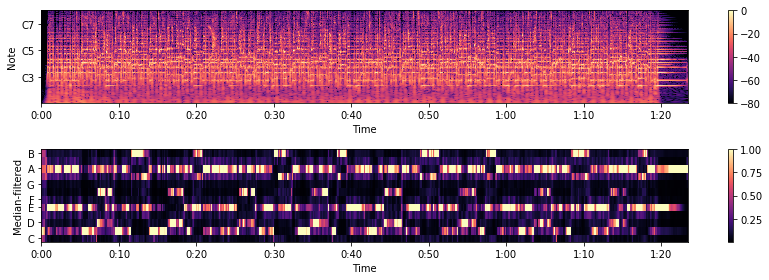

In [158]:
a = get_chromagram(TMP_SONG, True)

In [5]:
a = get_chromagram(CHORD_PATH_FOR_TEST)

In [49]:
13/(83/3593)

562.7590361445783

In [43]:
len(a[0])

3593

Идея: делить песни на аккорды и там уже определять что за аккорд. И потом смотреть, какого аккорда в этом промежутке времени больше всего выдало

In [188]:
def get_chord_changing_info(song_chromagram):
    ZERO_LOWER_LIMIT = 10
    NUM_OF_NOTES = 12
    
    note_playing_mask = song_chromagram.copy()
    # [12][many]
    
    for one_note_mask in note_playing_mask:
        #one_note_mask = note_playing_mask[note_num]
        # to boolean (1 - well heard, 0 - bad)
        for i in range(len(one_note_mask)):
            if one_note_mask[i] < 0.2:
                one_note_mask[i] = 0
            else:
                one_note_mask[i] = 1  
        
        for value in [0, 1]:
            # if single value delete it
            l = 0
            while l < len(one_note_mask):
                if one_note_mask[l] == value:
                    h = l + 1
                    while (h < len(one_note_mask)) and (one_note_mask[h] != value):
                        h += 1
                    if h - l < ZERO_LOWER_LIMIT:
                        one_note_mask[l: h] = [value for _ in range(l, h)]
                    l = h
                else:
                    l += 1

    chord_changes_on_index = []    
    chord = [note_playing_mask[note_num][0] for note_num in range(NUM_OF_NOTES)]
    for i in range(len(note_playing_mask[0]) - 1):            
        next_chord = [note_playing_mask[note_num][i+1] for note_num in range(NUM_OF_NOTES)]
        cnt = 0
        for note_num in range(len(chord)):
            if chord[note_num] != next_chord[note_num]:
                cnt += 1
        if cnt > 1:            
            chord_changes_on_index.append(i+1)
        chord = next_chord
        
    return chord_changes_on_index

In [189]:
info = get_chord_changing_info(get_chromagram(TMP_SONG))

In [190]:
for elem in info:
    t = elem*(83/3593)
    if t > 60:
        t -= 60
    print(t)

7.230448093515168
8.17756749234623
9.217088783746172
11.573337044252714
12.566657389368215
12.866963540217089
13.767881992763707
13.929585304759254
14.668800445310325
14.946006123016977
18.29557472863902
18.31867520178124
21.483440022265516
27.42026161981631
27.44336209295853
27.65126635123852
32.17895908711383
37.930976899526854
37.9771778458113
39.17840244920679
43.913999443362094
46.24714723072641
46.40885054272196
51.0751461174506
55.718341219037015
0.6618424714723048
0.9159476760367369
5.420539938769835
5.466740885054264
8.030893403840807
11.865571945449489
12.743389924853886
12.997495129418311
14.268021152240465
15.168939604787084


A B H C C#/Db D D#/Eb E F F#/Gb G G#/Ab

0 - 0.19143098572770695    C       
1 - 0.027945324576632867   C#/Db   
2 - 0.016974654905193527   D       
3 - 0.01323931850250817    D#/Eb   
4 - 0.04778102729823434    E
5 - 0.014215230874719952   F
6 - 0.048926188308303566   F#/Gb
7 - 1.0                    G
8 - 0.09528424450139342    G#/Ab
9 - 0.017434431788575927   A
10- 0.01048897659584237    A#/Bb
11- 0.0372162544027819     B

In [9]:
# формировать df!!!
# цикл по списку аккордов
    # цикл по аккорду (200 шт) DATA_DIR + CHPRDS + (i+1) + ".wav" 
        # загружать аккорд, 
        # брать в начале, в конце и в середине звучание
        # добавлять в таблицу 12 столбиков + индекс аккорда в 13 столбик
# сохранить df!

# откуда беру хронограмму: 1/8, 1/4, 1/2, 1-1/4, 1-1/8 из записи звучания аккорда

# list of chromagrams from audio has view:
# a[0-12 (note: C-B)][number of chromagram from all song]


def sounds_to_df(dir_path, chords, num_of_chords, file_format="wav", 
                 dest_file="chords_data.csv"):
    """
    Func loads audio file, gets data from it (chromagrams) 
    and saves it to DataFrame and then to csv file.
    
    Parameters:
        dir_path - directory with chords folders
        chords - list of chords (name like chords folders)
        num_of_chords (number of records of one chord)
        file_format - records format
        dest_file - destination file of data
    
    """
    
    COLUMNS = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 
               'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']
    COEFFICIENTS = [0.125, 0.25, 0.5, 0.75, 0.875]
    # dataframe of all data of chords view
    df = pd.DataFrame(columns=[*COLUMNS, "Chord"])
    # all chords
    for chord in chords:
        # all version of one chord
        for chord_num in range(num_of_chords):
            # chromagram of all audio of chord
            chord_chromagram = get_chromagram(
                "{0}\\{1}\\{2}{3}.{4}".format(
                    dir_path, chord, chord, chord_num+1, file_format)
            )
            # get some chromagrams from all audio
            for coef in COEFFICIENTS:
                # places of our chromagrams (from the center, the start & the end)
                index = int(len(chord_chromagram)*coef)

                chord_chromagram_slice = [
                    chord_chromagram[i][index] for i in range(12)
                ]
                
                chord_data = {
                    k: v for k, v in zip(COLUMNS, chord_chromagram_slice)
                }
                chord_data["Chord"] = chord                
                df = df.append(chord_data, ignore_index=True)                
    df = df.sample(frac=1)
    df.to_csv(dest_file, index=False)

In [151]:
DATA_DIR = "D:\\iba_project_data\\Guitar_Only"
CHORDS = ["a", "am", "bm", "c", "d", "dm", "e", "em", "f", "g"]
NUM_OF_CHORD_EXAMPLES = 200

sounds_to_df(DATA_DIR, CHORDS, NUM_OF_CHORD_EXAMPLES)

In [10]:
df = pd.read_csv("chords_data.csv")

In [11]:
le_chords = LabelEncoder()
df["chord_code"] = le_chords.fit_transform(df["Chord"])
df[["Chord", "chord_code"]].head(11)

,Chord,chord_code
0,f,8
1,a,0
2,c,3
3,a,0
4,a,0
5,e,6
6,c,3
7,dm,5
8,e,6
9,c,3


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = df.drop(['Chord', 'chord_code'], axis=1)
y = df['chord_code']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [15]:
from sklearn.linear_model import RidgeClassifier

In [16]:
rc_chord_classifier = RidgeClassifier(random_state=42)

In [17]:
rc_chord_classifier.fit(X_train, y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=42, solver='auto',
                tol=0.001)

In [18]:
y_pred = rc_chord_classifier.predict(X_test)

In [19]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [20]:
precision_score(y_test, y_pred, average="weighted")

0.8088363803577453

In [21]:
recall_score(y_test, y_pred, average="weighted")

0.8016

In [22]:
from catboost import CatBoostClassifier

In [23]:
cb_chord_classifier = CatBoostClassifier()
cb_chord_classifier.fit(X_train, y_train)

0:	learn: 2.1607537	total: 999ms	remaining: 16m 37s
1:	learn: 2.0426845	total: 1.5s	remaining: 12m 30s
2:	learn: 1.9389900	total: 1.99s	remaining: 11m 1s
3:	learn: 1.8456117	total: 2.49s	remaining: 10m 20s
4:	learn: 1.7623456	total: 2.98s	remaining: 9m 53s
5:	learn: 1.6877169	total: 3.53s	remaining: 9m 45s
6:	learn: 1.6203042	total: 4.01s	remaining: 9m 29s
7:	learn: 1.5595235	total: 4.5s	remaining: 9m 18s
8:	learn: 1.5031154	total: 5.05s	remaining: 9m 16s
9:	learn: 1.4506574	total: 5.62s	remaining: 9m 16s
10:	learn: 1.4035519	total: 6.16s	remaining: 9m 13s
11:	learn: 1.3566188	total: 6.71s	remaining: 9m 12s
12:	learn: 1.3128408	total: 7.17s	remaining: 9m 4s
13:	learn: 1.2727928	total: 7.8s	remaining: 9m 9s
14:	learn: 1.2342823	total: 8.26s	remaining: 9m 2s
15:	learn: 1.1983843	total: 8.71s	remaining: 8m 55s
16:	learn: 1.1651584	total: 9.18s	remaining: 8m 50s
17:	learn: 1.1328229	total: 9.69s	remaining: 8m 48s
18:	learn: 1.1029082	total: 10.2s	remaining: 8m 46s
19:	learn: 1.0744043	tota

157:	learn: 0.2048961	total: 1m 31s	remaining: 8m 7s
158:	learn: 0.2038458	total: 1m 31s	remaining: 8m 6s
159:	learn: 0.2025899	total: 1m 32s	remaining: 8m 5s
160:	learn: 0.2011574	total: 1m 33s	remaining: 8m 5s
161:	learn: 0.2000263	total: 1m 33s	remaining: 8m 4s
162:	learn: 0.1987862	total: 1m 34s	remaining: 8m 3s
163:	learn: 0.1974135	total: 1m 34s	remaining: 8m 2s
164:	learn: 0.1963610	total: 1m 35s	remaining: 8m 1s
165:	learn: 0.1952977	total: 1m 35s	remaining: 8m
166:	learn: 0.1943408	total: 1m 36s	remaining: 8m
167:	learn: 0.1932225	total: 1m 36s	remaining: 7m 59s
168:	learn: 0.1920168	total: 1m 37s	remaining: 7m 58s
169:	learn: 0.1910280	total: 1m 38s	remaining: 7m 58s
170:	learn: 0.1900087	total: 1m 38s	remaining: 7m 57s
171:	learn: 0.1889020	total: 1m 39s	remaining: 7m 57s
172:	learn: 0.1876298	total: 1m 39s	remaining: 7m 56s
173:	learn: 0.1865342	total: 1m 40s	remaining: 7m 56s
174:	learn: 0.1856593	total: 1m 40s	remaining: 7m 55s
175:	learn: 0.1845541	total: 1m 41s	remainin

310:	learn: 0.1072788	total: 3m	remaining: 6m 39s
311:	learn: 0.1070168	total: 3m	remaining: 6m 38s
312:	learn: 0.1068401	total: 3m 1s	remaining: 6m 38s
313:	learn: 0.1064828	total: 3m 2s	remaining: 6m 37s
314:	learn: 0.1061474	total: 3m 2s	remaining: 6m 37s
315:	learn: 0.1057086	total: 3m 3s	remaining: 6m 36s
316:	learn: 0.1054780	total: 3m 3s	remaining: 6m 35s
317:	learn: 0.1050857	total: 3m 4s	remaining: 6m 35s
318:	learn: 0.1047657	total: 3m 5s	remaining: 6m 35s
319:	learn: 0.1044677	total: 3m 5s	remaining: 6m 34s
320:	learn: 0.1041808	total: 3m 6s	remaining: 6m 34s
321:	learn: 0.1039327	total: 3m 6s	remaining: 6m 33s
322:	learn: 0.1037303	total: 3m 7s	remaining: 6m 32s
323:	learn: 0.1034239	total: 3m 7s	remaining: 6m 32s
324:	learn: 0.1030921	total: 3m 8s	remaining: 6m 31s
325:	learn: 0.1026805	total: 3m 8s	remaining: 6m 30s
326:	learn: 0.1024072	total: 3m 9s	remaining: 6m 30s
327:	learn: 0.1020870	total: 3m 10s	remaining: 6m 29s
328:	learn: 0.1017542	total: 3m 10s	remaining: 6m 2

464:	learn: 0.0725245	total: 4m 19s	remaining: 4m 58s
465:	learn: 0.0723409	total: 4m 19s	remaining: 4m 57s
466:	learn: 0.0722020	total: 4m 20s	remaining: 4m 56s
467:	learn: 0.0720710	total: 4m 20s	remaining: 4m 56s
468:	learn: 0.0719732	total: 4m 21s	remaining: 4m 55s
469:	learn: 0.0717826	total: 4m 21s	remaining: 4m 55s
470:	learn: 0.0716280	total: 4m 22s	remaining: 4m 54s
471:	learn: 0.0714157	total: 4m 22s	remaining: 4m 53s
472:	learn: 0.0712545	total: 4m 23s	remaining: 4m 53s
473:	learn: 0.0711066	total: 4m 23s	remaining: 4m 52s
474:	learn: 0.0709391	total: 4m 24s	remaining: 4m 52s
475:	learn: 0.0708520	total: 4m 24s	remaining: 4m 51s
476:	learn: 0.0707277	total: 4m 25s	remaining: 4m 50s
477:	learn: 0.0706152	total: 4m 25s	remaining: 4m 50s
478:	learn: 0.0704778	total: 4m 26s	remaining: 4m 49s
479:	learn: 0.0702660	total: 4m 26s	remaining: 4m 49s
480:	learn: 0.0700726	total: 4m 27s	remaining: 4m 48s
481:	learn: 0.0698890	total: 4m 28s	remaining: 4m 48s
482:	learn: 0.0697484	total:

617:	learn: 0.0535379	total: 5m 34s	remaining: 3m 26s
618:	learn: 0.0534559	total: 5m 34s	remaining: 3m 26s
619:	learn: 0.0533345	total: 5m 35s	remaining: 3m 25s
620:	learn: 0.0532211	total: 5m 35s	remaining: 3m 24s
621:	learn: 0.0531309	total: 5m 36s	remaining: 3m 24s
622:	learn: 0.0530260	total: 5m 36s	remaining: 3m 23s
623:	learn: 0.0529232	total: 5m 37s	remaining: 3m 23s
624:	learn: 0.0528241	total: 5m 37s	remaining: 3m 22s
625:	learn: 0.0527734	total: 5m 37s	remaining: 3m 21s
626:	learn: 0.0527248	total: 5m 38s	remaining: 3m 21s
627:	learn: 0.0526040	total: 5m 38s	remaining: 3m 20s
628:	learn: 0.0525382	total: 5m 39s	remaining: 3m 20s
629:	learn: 0.0524386	total: 5m 39s	remaining: 3m 19s
630:	learn: 0.0523519	total: 5m 40s	remaining: 3m 19s
631:	learn: 0.0522291	total: 5m 40s	remaining: 3m 18s
632:	learn: 0.0521434	total: 5m 41s	remaining: 3m 17s
633:	learn: 0.0520400	total: 5m 41s	remaining: 3m 17s
634:	learn: 0.0519628	total: 5m 42s	remaining: 3m 16s
635:	learn: 0.0518417	total:

770:	learn: 0.0418690	total: 6m 49s	remaining: 2m 1s
771:	learn: 0.0418247	total: 6m 50s	remaining: 2m 1s
772:	learn: 0.0417421	total: 6m 50s	remaining: 2m
773:	learn: 0.0416805	total: 6m 51s	remaining: 2m
774:	learn: 0.0416144	total: 6m 51s	remaining: 1m 59s
775:	learn: 0.0415707	total: 6m 52s	remaining: 1m 59s
776:	learn: 0.0415243	total: 6m 52s	remaining: 1m 58s
777:	learn: 0.0414725	total: 6m 53s	remaining: 1m 57s
778:	learn: 0.0414002	total: 6m 53s	remaining: 1m 57s
779:	learn: 0.0413495	total: 6m 54s	remaining: 1m 56s
780:	learn: 0.0413161	total: 6m 54s	remaining: 1m 56s
781:	learn: 0.0412421	total: 6m 55s	remaining: 1m 55s
782:	learn: 0.0411883	total: 6m 55s	remaining: 1m 55s
783:	learn: 0.0411153	total: 6m 56s	remaining: 1m 54s
784:	learn: 0.0410439	total: 6m 56s	remaining: 1m 54s
785:	learn: 0.0409844	total: 6m 57s	remaining: 1m 53s
786:	learn: 0.0409178	total: 6m 57s	remaining: 1m 53s
787:	learn: 0.0408512	total: 6m 58s	remaining: 1m 52s
788:	learn: 0.0408133	total: 6m 58s	re

925:	learn: 0.0337878	total: 8m 4s	remaining: 38.7s
926:	learn: 0.0337510	total: 8m 5s	remaining: 38.2s
927:	learn: 0.0337031	total: 8m 5s	remaining: 37.7s
928:	learn: 0.0336643	total: 8m 6s	remaining: 37.2s
929:	learn: 0.0336268	total: 8m 6s	remaining: 36.6s
930:	learn: 0.0336067	total: 8m 7s	remaining: 36.1s
931:	learn: 0.0335500	total: 8m 7s	remaining: 35.6s
932:	learn: 0.0335142	total: 8m 8s	remaining: 35.1s
933:	learn: 0.0334570	total: 8m 8s	remaining: 34.5s
934:	learn: 0.0334102	total: 8m 9s	remaining: 34s
935:	learn: 0.0333825	total: 8m 9s	remaining: 33.5s
936:	learn: 0.0333504	total: 8m 9s	remaining: 32.9s
937:	learn: 0.0333277	total: 8m 10s	remaining: 32.4s
938:	learn: 0.0332732	total: 8m 10s	remaining: 31.9s
939:	learn: 0.0332421	total: 8m 11s	remaining: 31.4s
940:	learn: 0.0331869	total: 8m 11s	remaining: 30.8s
941:	learn: 0.0331400	total: 8m 12s	remaining: 30.3s
942:	learn: 0.0331069	total: 8m 12s	remaining: 29.8s
943:	learn: 0.0330747	total: 8m 13s	remaining: 29.3s
944:	le

In [24]:
y_pred = cb_chord_classifier.predict(X_test)

In [25]:
precision_score(y_test, y_pred, average="weighted")

0.9837670902300538

In [26]:
recall_score(y_test, y_pred, average="weighted")

0.9836

In [27]:
a = get_chromagram(TMP_SONG)

In [28]:
COLUMNS = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 
           'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']
# dataframe of all data of chords view
df = pd.DataFrame(columns=COLUMNS)

In [32]:
len(a[0])

3593

In [35]:
for index in range(len(a[0])):
    # places of our chromagrams (from the center, the start & the end)
    chord_chromagram_slice = [
        a[i][index] for i in range(12)
    ]
                
    chord_data = {
        k: v for k, v in zip(COLUMNS, chord_chromagram_slice)
    }               
    df = df.append(chord_data, ignore_index=True)      

In [36]:
df

,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,A,A#/Bb,B
0,0.600371,0.789064,0.273008,0.208916,0.378533,0.173327,0.110613,0.163998,0.390412,0.513270,0.382431,0.517301
1,0.600371,0.789064,0.273008,0.208916,0.378533,0.173327,0.110613,0.163998,0.390412,0.513270,0.382431,0.517301
2,0.600371,0.789064,0.273008,0.208916,0.378533,0.173327,0.102606,0.161917,0.383196,0.513270,0.374386,0.517301
3,0.545549,0.867716,0.273008,0.208916,0.378533,0.173327,0.102606,0.161917,0.383196,0.566978,0.378944,0.500969
4,0.536439,0.867716,0.273008,0.208916,0.378533,0.177229,0.102606,0.161917,0.390412,0.573330,0.378944,0.500969
...,...,...,...,...,...,...,...,...,...,...,...,...
3588,0.007407,0.030206,0.003797,0.003530,0.022037,0.003754,0.006407,0.022964,0.158312,1.000000,0.133995,0.048881
3589,0.007638,0.021437,0.003815,0.003781,0.014688,0.004487,0.007492,0.029890,0.189858,1.000000,0.144235,0.049495
3590,0.007918,0.015228,0.003858,0.004443,0.013716,0.006018,0.009886,0.042083,0.202885,1.000000,0.163654,0.048257
3591,0.007918,0.015228,0.003858,0.004443,0.013716,0.006018,0.009886,0.042083,0.202885,1.000000,0.163654,0.041738


In [37]:
y_pred = cb_chord_classifier.predict(df)

In [49]:
mapping = {0: "a", 1: "am", 2: "bm", 3: "c", 4: "d", 5: "dm", 6: "e", 7: "em", 8: "f", 9: "g"}
last = ""
for chord in y_pred:
    if last != mapping[int(chord[0])]:
        last = mapping[int(chord[0])]
        print(last)

d
dm
am
a
c
a
am
a
am
a
am
d
a
d
am
a
am
a
am
a
dm
a
e
am
a
am
a
dm
d
dm
d
dm
d
a
e
am
a
dm
a
dm
d
dm
d
a
d
a
dm
a
dm
am
a
c
e
em
am
a
am
a
dm
d
a
am
a
am
e
am
a
dm
a
d
dm
d
a
dm
a
am
e
a
am
d
dm
d
a
dm
a
e
am
a
dm
a
dm
a
am
dm
a
dm
d
dm
d
a
am
a
am
a
dm
a
c
a
e
a
d
a
dm
am
a
d
a
d
dm
a
am
e
am
a


A B H C C#/Db D D#/Eb E F F#/Gb G G#/Ab

Далее нужно добавить способ разделения песни на аккорды.